In [ ]:
# LIGAR GPU PARA EXECUTAR O CÓDIGO
# Verifica se a GPU está disponível
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import pandas as pd           # data manipulation and analysis library -> permite criar dataframes
import numpy as np            # biblioteca de computação científica
import matplotlib.pyplot as plt

import yfinance as yf         # Biblioteca para acessar dados do Yahoo Finance
ticker = 'AAPL'
# Download dos dados via Yahoo Finance API

data = yf.download(ticker, start='2010-07-01', end = '2020-07-01', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Extração de features
feature = pd.DataFrame(index=data.index)      # Cria um dataframe dos features, inicialmente vazio, apenas com os dias e horários

# Média Móvel de 14 intervalos de tempo
#feature['SMA'] = data['Close'].rolling(window=14).mean()


# Moving Average Convergence Divergence (MACD)
short_ema = data['Close'].ewm(span=12, adjust=False).mean()  # Short EMA with 12-day span
long_ema = data['Close'].ewm(span=26, adjust=False).mean()   # Long EMA with 26-day span
feature['MACD'] = short_ema - long_ema                            # MACD line; MACD > 0 (TENDENCIA DE SUBIDA); C.C TENDENCIA DE QUEDA

# Relative Strength Index (RSI)
delta = data['Close'].diff()# Cálculo da diferença x(t) - x(t-1) (primeiro elemento -> NaN); Delta -> vetor com as diferenças
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean() # Calcula MA do delta, considerando apenas os valores positivos (os valores nulos e negativos são trocador por 0)
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()# Calcula MA de -1*delta, considerando apenas os valores negativos
rs = gain / loss                                                  # Relative Strength
feature['RSI'] = 100 - (100 / (1 + rs))                           # RSI formula

#Bolling Bands
window = 20  # Typical period
middle_band = data['Close'].rolling(window=window).mean()
upper_band = middle_band + 2 * data['Close'].rolling(window=window).std()
lower_band = middle_band - 2 * data['Close'].rolling(window=window).std()
#feature['Middle_Band'] = middle_band
#feature['Upper_Band'] = upper_band
#feature['Lower_Band'] = lower_band

#Stochastic Oscillator
low_min = data['Low'].rolling(window=14).min()
high_max = data['High'].rolling(window=14).max()
feature['Stochastic %K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))

#Average True Range
high_low = data['High'] - data['Low']
high_close = np.abs(data['High'] - data['Close'].shift())
low_close = np.abs(data['Low'] - data['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
#feature['ATR'] = true_range.rolling(window=14).mean()

# Commodity Channel Index
typical_price = (data['High'] + data['Low'] + data['Close']) / 3
mean_tp = typical_price.rolling(window=20).mean()
mad = typical_price.rolling(window=20).apply(lambda x: np.fabs(x - x.mean()).mean())
feature['CCI'] = (typical_price - mean_tp) / (0.015 * mad)

#Money Flow Index
typical_price = (data['High'] + data['Low'] + data['Close']) / 3
money_flow = typical_price * data['Volume']
positive_flow = money_flow.where(typical_price > typical_price.shift(), 0)
negative_flow = money_flow.where(typical_price < typical_price.shift(), 0)
positive_flow_sum = positive_flow.rolling(window=14).sum()
negative_flow_sum = negative_flow.rolling(window=14).sum()
money_flow_ratio = positive_flow_sum / negative_flow_sum
feature['MFI'] = 100 - (100 / (1 + money_flow_ratio))

In [ ]:
#Volume
feature['Volume'] = data['Volume']

# Adiciona o preço de fechamento como feature também
feature['Close'] = data['Close']

# Joga fora as linhas com NaN do dataframe de feature e do dataframe com dados do S&P 500
feature = feature.dropna()
data = data.dropna()

# Normaliza o dataframe feature utilizando a média e desvio padrão
mean = feature.mean()   # Armazena a média dos valores dos features em mean
std = feature.std()     # Armazena o desvio padrão dos valores dos features em std
feature = (feature - mean) / std    # Normaliza os valores dos features -> Média 0 e Desvio Padrão 1

corr_matrix = feature.corr()
print(corr_matrix['Close'].sort_values(ascending=False))

Close            1.000000
MACD             0.371216
Stochastic %K    0.143546
CCI              0.143245
RSI              0.143147
MFI              0.113418
Volume          -0.546685
Name: Close, dtype: float64


In [ ]:
TRAIN_DATA_RATIO = 0.7                      # 70% do dataset será utilizado para treinamento                                          # 30% do dataset será utilizado para Teste
NUMBER_OF_SERIES_FOR_PREDICTION = 24        # Utiliza os últimos 24 pontos para realizar a predição do próximo ponto

In [ ]:
import tensorflow as tf                                 # Importa framework de aprendizado profundo
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError   # Função de Otimizição
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam            # Modelo de Otimização
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Funções que ajudam no treinamento
from tensorflow.keras.regularizers import l2

# Função que transforma o dataset em sequências para a predição
# Entrada: dataset (de treinamento ou teste) e o número de pontos anteriores que serão utilizados para fazer a predição do próximo ponto.
def create_dataset(dataset, number_of_series_for_prediction=24):
    X_data, y_data = [], []      # Inicializa dois vetores para armazenar a sequência de entrada (X_data) e a respectivo target (y_data)
    data_np = np.array(dataset)  # Converte o dataset para um array numpy -> deixa o método mais eficiente
    for i in range(len(data_np) - number_of_series_for_prediction):      # Iteração sobre o dataset para criar sequÊncias de 24 elementos
        X_data.append(data_np[i: i + number_of_series_for_prediction])   # Anexa como entrada 24 elementos contando a partir da posição i
        y_data.append(data_np[i + number_of_series_for_prediction, -1])  # -1 -> ÚLTIMA COLUNA, OU SEJA, TARGET É O CLOSING PRICE !!!!!!
    return np.array(X_data), np.array(y_data) # Retorna X_data: sequencias de 24 elementos e y_data: targets (CLOSING PRICES) dessas sequencias de 24 elementos

X_all, y_all = create_dataset(feature, NUMBER_OF_SERIES_FOR_PREDICTION)
total_samples = len(X_all)
train_size = int(total_samples * TRAIN_DATA_RATIO)


X_train = X_all[:train_size]
y_train = y_all[:train_size]


X_test = X_all[train_size :]
y_test = y_all[train_size :]

# DEFINIÇÕES DO TRANSFORMER
# Definição do bloco encoder do Transformer
def transformer_block(inputs, model_dim, num_heads, ff_dim, dropout=0.2):   #ALTEROU DE 0.1 PARA 0.2
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(inputs, inputs) #permite o transformer analisar diferentes partes da sequencia
    attention_output = Dropout(dropout)(attention_output) #previne overfitting através da técnica de dropout
    output1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    #feed-forward network
    ff_output = Dense(ff_dim, activation='relu', kernel_regularizer=l2(1e-4))(output1)
    ff_output = Dense(model_dim, kernel_regularizer=l2(1e-4))(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    output2 = LayerNormalization(epsilon=1e-6)(output1 + ff_output)

    return output2

# Definição da função de positional encoding
def positional_encoding(max_position, model_dim):
    angle_rads = np.arange(max_position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(model_dim)[np.newaxis, :] // 2)) / np.float32(model_dim))
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Constução do modelo Transformer
def build_transformer_model(input_shape, model_dim, num_heads, num_layers, ff_dim, output_dim, dropout=0.1):
    inputs = Input(input_shape)
    x = Dense(model_dim)(inputs)
    x = x + positional_encoding(input_shape[0], model_dim)
    for _ in range(num_layers):
        x = transformer_block(x, model_dim, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(output_dim)(x)
    return Model(inputs, outputs)

input_shape = (X_train.shape[1], X_train.shape[2])  # Tamanho da sequência, Número de features
model_dim = 128                                     # OU 64 (ANTES ERA 512) -> DIMINUIR FF_DIM PROPORCIONALMENTE
num_heads = 4                                       # ANTES ERA 8
num_layers = 2                                      # Número de blocos transformers
ff_dim = 256                                        # ANTES ERA 1024 -> MANTER PROPORÇÃO
output_dim = 1

# Constrói o modelo e compila
model = build_transformer_model(input_shape, model_dim, num_heads, num_layers, ff_dim, output_dim)
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Função que ajusta o learning rate durante o treinamento
def custom_lr_schedule(epoch, lr):
    warmup_epochs = 10  # Número de epocas que o learning rate irá crescer do valor de warmup até o inicial
    warmup_lr = 1e-4
    initial_lr = 1e-3
    decay_rate = 0.4    # Taxa de decaimento após fase de warmup (multiplica o learning rate por esse valor a cada passo)
    decay_step = 10
    return warmup_lr + (initial_lr - warmup_lr) * (epoch / warmup_epochs) if epoch < warmup_epochs else initial_lr * (decay_rate ** ((epoch - warmup_epochs) / decay_step))




In [ ]:
# Callbacks
#Interrompe o treinamento se a validation loss não melhorar em 25 épocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

#Salva o modelo sempre que houver melhoria no validation loss
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='val_loss')

# Reduz o learning rate se o modelo não tiver melhorias no validation loss (multiplica por um fator de 0.5 após 5 épocas consecutivas sem melhorias)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Parâmetros de treinamento
num_epochs=200
batch_size=128

# TREINA O MODELO !!
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=batch_size,
          callbacks=[early_stopping, model_checkpoint, LearningRateScheduler(custom_lr_schedule)], shuffle = 'False')


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.3638 - val_loss: 1.2082 - learning_rate: 1.0000e-04
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1478 - val_loss: 0.5707 - learning_rate: 1.9000e-04
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0914 - val_loss: 0.1375 - learning_rate: 2.8000e-04
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0803 - val_loss: 0.1484 - learning_rate: 3.7000e-04
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0756 - val_loss: 0.1519 - learning_rate: 4.6000e-04
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0755 - val_loss: 0.1718 - learning_rate: 5.5000e-04
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0742 - val_loss: 0.1436 - learning_rate: 6.4000e-04
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0746 - val_loss: 0.1436 - learning_rate: 7.3000e-04
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0752 - val_loss: 0.1808 - l

In [ ]:
test_data=feature.iloc[train_size:]
train_data=feature.iloc[:train_size]

# Utiliza o modelo treinado para prever os dados de teste, retirando a normalização dos dados e transformando em um único vetor
predictions = model.predict(X_test[0:618]).flatten() * std['Close'] + mean['Close']

# Extrai os valores target correspondentes e armazena em actual_close_prices
test_indices = test_data.index[NUMBER_OF_SERIES_FOR_PREDICTION:642]
actual_close_prices = data.Close.loc[test_indices].values

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


In [ ]:
#TREINAMENTO
# Denormalize predictions
#predictions = model.predict(X_train).flatten() * std['Close'] + mean['Close']

# Denormalize actual Close prices
#actual_close_prices = y_train * std['Close'] + mean['Close']

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
#print(test_data[0:642])
#print(X_test[0:642])


print(len(predictions))
print(len(actual_close_prices))

618
618


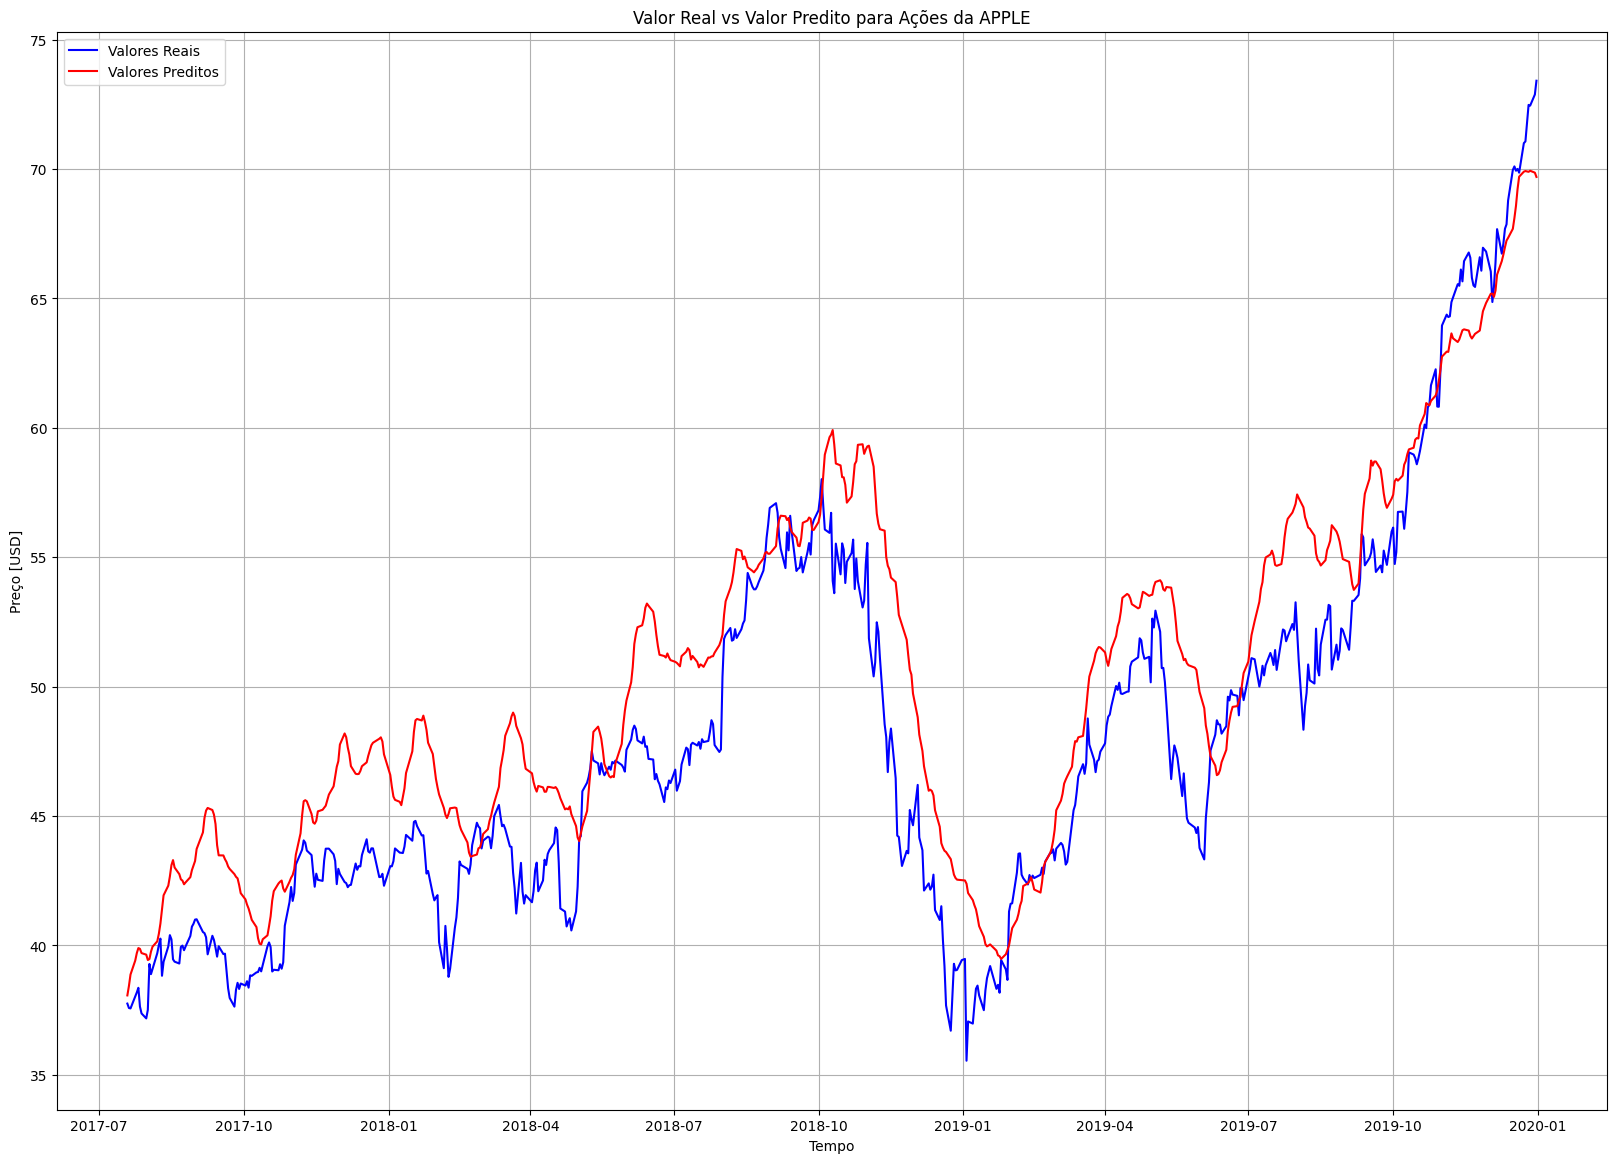

In [ ]:
# Plotting the results
plt.figure(figsize=(20, 14))
plt.plot(test_indices, actual_close_prices, label='Valores Reais', color='blue')
plt.plot(test_indices, predictions, label='Valores Preditos', color='red')
plt.title('Valor Real vs Valor Predito para Ações da APPLE')
plt.xlabel('Tempo')
plt.ylabel('Preço [USD]')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Root Mean Squared Error
rmse=0
for i in range(len(predictions)):
  rmse += (predictions[i] - actual_close_prices[i])**2
rmse = np.sqrt(rmse/len(predictions))
print(f'RMSE: {rmse}')

RMSE: [3.37391811]


In [ ]:
# Acurácia de direção
# Compara cada valor consecutivo: x(t) > x(t+1) -> Se sim, guarda o valor 1, c.c, guarda o valor 0 no vetor data_dir (1 representa queda; 0 subida)

data_dir = np.where(actual_close_prices[:-1] > actual_close_prices[1:], 1, 0) # Vetor com 0s (subidas) e 1s (quedas)
data_dir = np.transpose(data_dir)
data_dir = data_dir[0]
pred_dir = np.where(predictions[:-1] > predictions[1:], 1, 0)                 # Vetor com 0s e 1s
dir_acc = np.mean(data_dir == pred_dir)   # Compara valor por valor, e atribui 1 para verdadeiro e 0 para falso, depois tira a média disso
                                          # dir_acc = 1 (predição perfeita), dir_acc=0 (errou todos); dir_acc=0.5(acertou metade)
print(f'Acurácia de direção: {dir_acc}')

Acurácia de direção: 0.5601156069364162
